<a href="https://colab.research.google.com/github/kamaleshw781-cmd/kamalesh/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install --upgrade pip setuptools wheel --quiet
!pip install --quiet "scikit-learn>=1.4.2" pandas numpy matplotlib joblib
!pip install --quiet lightgbm xgboost lime shap==0.41.0
!pip install --quiet jedi


In [36]:
import warnings, os, time
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

try:
    import lightgbm as lgb
except:
    lgb = None
try:
    import xgboost as xgb
except:
    xgb = None
try:
    import shap
except:
    shap = None
try:
    import lime.lime_tabular
except:
    lime = None


In [38]:
csv_path = '/content/credit_risk_dataset.csv'
if not os.path.exists(csv_path):
    raise SystemExit(f"File not found at {csv_path}.")
df = pd.read_csv(csv_path)
print(df.shape)
df.head()



(32581, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [39]:
print(df.info())
target = 'loan_status'
print(df[target].value_counts(dropna=False))
(df.isna().mean()*100).sort_values(ascending=False).head(20)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None
loan_status
0    25473
1  

,0
loan_int_rate,9.563856
person_emp_length,2.747000
person_income,0.000000
person_age,0.000000
person_home_ownership,0.000000
loan_intent,0.000000
loan_grade,0.000000
loan_amnt,0.000000
loan_status,0.000000
loan_percent_income,0.000000


In [40]:
missing = df.isna().sum()
numeric_candidates = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_with_na = [c for c in numeric_candidates if df[c].isna().any()]
for c in num_with_na:
    df[c].fillna(df[c].median(), inplace=True)

cat_candidates = df.select_dtypes(include=['object','category']).columns.tolist()
cat_with_na = [c for c in cat_candidates if df[c].isna().any()]
for c in cat_with_na:
    df[c].fillna('MISSING', inplace=True)

df.isna().sum().sum()


np.int64(0)

In [42]:
if {'loan_amnt','person_income'}.issubset(df.columns):
    df['dti_amnt'] = df['loan_amnt'] / (df['person_income'] + 1)
if 'person_income' in df.columns:
    df['log_income'] = np.log1p(df['person_income'])
df.shape


(32581, 14)

In [43]:
X = df.drop(columns=['loan_status'])
y = df['loan_status'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape


((26064, 13), (6517, 13))

In [44]:
numeric_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()
numeric_cols, categorical_cols


(['person_age',
  'person_income',
  'person_emp_length',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_cred_hist_length',
  'dti_amnt',
  'log_income'],
 ['person_home_ownership',
  'loan_intent',
  'loan_grade',
  'cb_person_default_on_file'])

In [45]:
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('ohe', ohe)
])

preprocessor = ColumnTransformer(
    [('num', num_pipe, numeric_cols),
     ('cat', cat_pipe, categorical_cols)],
    sparse_threshold=0
)

preprocessor.fit(X_train)


ColumnTransformer(sparse_threshold=0,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length', 'dti_amnt',
                                  'log_income']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file'])])

In [46]:
def get_feature_names(preproc, numeric_cols, categorical_cols):
    out = []
    out.extend(numeric_cols)
    ohe = preproc.named_transformers_['cat'].named_steps['ohe']
    out.extend(list(ohe.get_feature_names_out(categorical_cols)))
    return out

feature_names = get_feature_names(preprocessor, numeric_cols, categorical_cols)
len(feature_names)


28

In [51]:
best_lgb = None
probs_lgb = None
if lgb is not None:
    lgb_pipe = Pipeline([('pre', preprocessor), ('model', lgb.LGBMClassifier(objective='binary', n_estimators=500, random_state=42))])
    param_dist = {
        'model__num_leaves': [31,50,80],
        'model__learning_rate': [0.01,0.05,0.1],
        'model__min_child_samples': [10,20,50],
        'model__subsample': [0.6,0.8,1.0],
        'model__colsample_bytree': [0.6,0.8,1.0]
    }
    rnd = RandomizedSearchCV(lgb_pipe, param_dist, n_iter=12, scoring='roc_auc', cv=3, random_state=42, n_jobs=1)
    rnd.fit(X_train, y_train)
    best_lgb = rnd.best_estimator_
    probs_lgb = best_lgb.predict_proba(X_test)[:,1]
    roc_auc_score(y_test, probs_lgb), average_precision_score(y_test, probs_lgb)
else:
    "LightGBM not available"


[LightGBM] [Info] Number of positive: 3791, number of negative: 13585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 17376, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218174 -> initscore=-1.276336
[LightGBM] [Info] Start training from score -1.276336
[LightGBM] [Info] Number of positive: 3791, number of negative: 13585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 17376, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218174 -> initscore=-1.276336
[LightGBM] [Info] Start training from score -1.276336
[LightGBM] [In

In [52]:
best_xgb = None
probs_xgb = None
if xgb is not None:
    xgb_pipe = Pipeline([('pre', preprocessor), ('model', xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc', n_estimators=500, random_state=42))])
    param_dist_xgb = {
        'model__max_depth': [3,5,7],
        'model__learning_rate': [0.01,0.05,0.1],
        'model__subsample': [0.6,0.8,1.0],
        'model__colsample_bytree': [0.6,0.8,1.0],
        'model__reg_alpha': [0,0.1,1]
    }
    rnd_xgb = RandomizedSearchCV(xgb_pipe, param_dist_xgb, n_iter=12, scoring='roc_auc', cv=3, random_state=42, n_jobs=1)
    rnd_xgb.fit(X_train, y_train)
    best_xgb = rnd_xgb.best_estimator_
    probs_xgb = best_xgb.predict_proba(X_test)[:,1]
    roc_auc_score(y_test, probs_xgb), average_precision_score(y_test, probs_xgb)
else:
    "XGBoost not available"


In [53]:
scores = {'logistic': roc_auc_score(y_test, probs_lr)}
if probs_lgb is not None:
    scores['lightgbm'] = roc_auc_score(y_test, probs_lgb)
if probs_xgb is not None:
    scores['xgboost'] = roc_auc_score(y_test, probs_xgb)

best_model_name = max(scores, key=scores.get)
best_model = {'logistic': lr_pipeline, 'lightgbm': best_lgb, 'xgboost': best_xgb}[best_model_name]
best_probs = {'logistic': probs_lr, 'lightgbm': probs_lgb, 'xgboost': probs_xgb}[best_model_name]
scores, best_model_name


({'logistic': np.float64(0.8832798488355562),
  'lightgbm': np.float64(0.9534762163064917),
  'xgboost': np.float64(0.9551405158528051)},
 'xgboost')

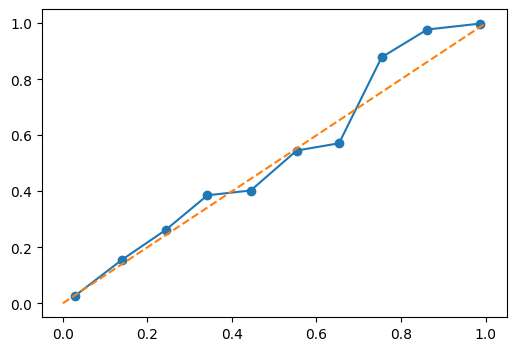

np.float64(0.05075581238021737)

In [54]:
brier = brier_score_loss(y_test, best_probs)
frac_pos, mean_pred = calibration_curve(y_test, best_probs, n_bins=10)
plt.figure(figsize=(6,4))
plt.plot(mean_pred, frac_pos, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.show()
brier


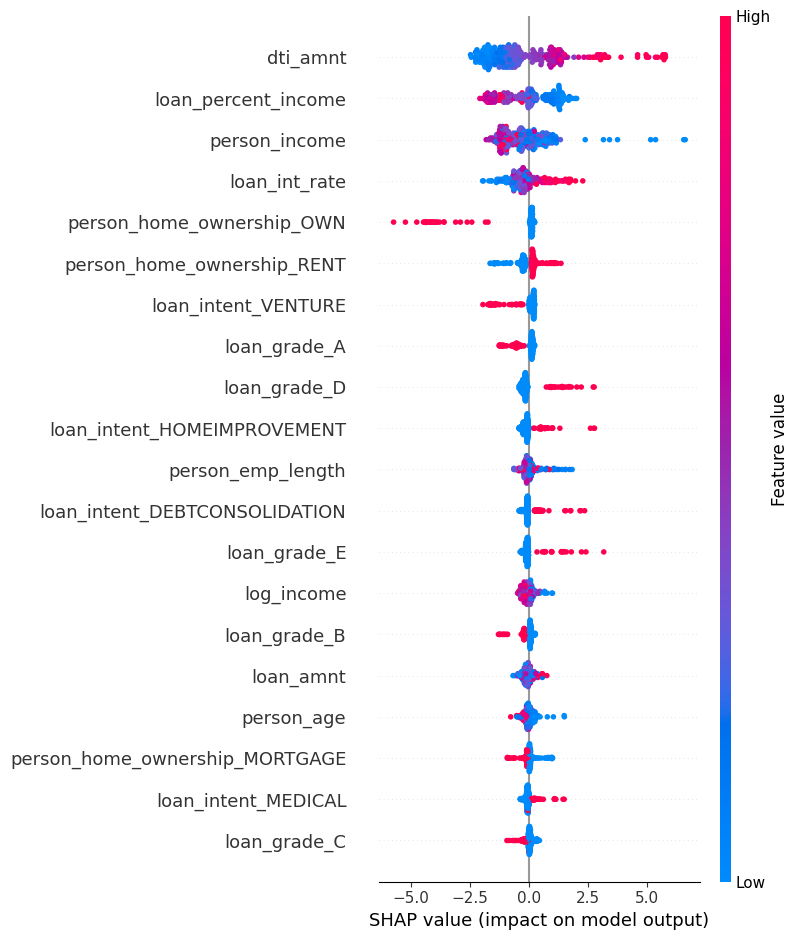

In [55]:
if shap is not None:
    background = X_train.sample(n=min(300, len(X_train)), random_state=42)
    background_trans = preprocessor.transform(background)

    if best_model_name in ('lightgbm','xgboost'):
        model_for_shap = best_model.named_steps['model']
        explainer = shap.TreeExplainer(model_for_shap)
        shap_values = explainer.shap_values(background_trans)
        shap_arr = shap_values[1] if isinstance(shap_values, list) else shap_values
    else:
        shap_arr = None

    if shap_arr is not None:
        shap.summary_plot(shap_arr, background_trans, feature_names=feature_names)
else:
    "SHAP not available"


In [56]:
if lime is not None:
    X_train_trans = preprocessor.transform(X_train)
    X_test_trans = preprocessor.transform(X_test)
    preds = best_model.predict_proba(X_test)[:,1]

    low_idx = np.argmin(preds)
    high_idx = np.argmax(preds)
    border_idx = np.argmin(np.abs(preds - 0.5))
    sample_idxs = [low_idx, border_idx, high_idx]
    sample_names = ['low_risk', 'borderline', 'high_risk']

    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_trans,
        feature_names=feature_names,
        class_names=['no_default','default'],
        mode='classification',
        discretize_continuous=True
    )

    for idx, name in zip(sample_idxs, sample_names):
        inst = X_test_trans[idx]
        exp = explainer.explain_instance(inst, best_model.named_steps['model'].predict_proba, num_features=8)
        print(name, exp.as_list())
else:
    "LIME not available"

os.makedirs('/content/artifacts', exist_ok=True)
joblib.dump(preprocessor, '/content/artifacts/preprocessor.joblib')
joblib.dump(best_model, '/content/artifacts/best_model.joblib')

report = {
    'n_rows': int(df.shape[0]),
    'n_features_raw': len(df.columns)-1,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'best_model': best_model_name,
    'test_auc_scores': scores,
    'brier_score': float(brier)
}
report


low_risk [('dti_amnt <= -0.75', -0.4057759319967469), ('loan_percent_income <= -0.75', 0.3756263074432156), ('person_home_ownership_OWN > 0.00', -0.32993587821399806), ('loan_grade_F <= 0.00', -0.17748230123927383), ('loan_grade_D <= 0.00', -0.1769246752814886), ('loan_intent_HOMEIMPROVEMENT <= 0.00', -0.1520552715232196), ('loan_grade_E <= 0.00', -0.13567590648800276), ('loan_grade_G <= 0.00', -0.0908287762026634)]
borderline [('dti_amnt > 0.54', 0.45592175038603716), ('person_home_ownership_OWN <= 0.00', 0.3010905425852405), ('loan_percent_income > 0.56', -0.2615992795265034), ('loan_grade_F <= 0.00', -0.2114038452762445), ('loan_grade_G <= 0.00', -0.18899508848654858), ('loan_grade_E <= 0.00', -0.17945745539080993), ('loan_intent_HOMEIMPROVEMENT > 0.00', 0.17189438733570497), ('loan_grade_D <= 0.00', -0.1509061631675373)]
high_risk [('dti_amnt > 0.54', 0.4535384435010444), ('person_home_ownership_OWN <= 0.00', 0.32786584840643884), ('loan_percent_income > 0.56', -0.24683787398174276

{'n_rows': 32581,
 'n_features_raw': 13,
 'numeric_cols': ['person_age',
  'person_income',
  'person_emp_length',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_cred_hist_length',
  'dti_amnt',
  'log_income'],
 'categorical_cols': ['person_home_ownership',
  'loan_intent',
  'loan_grade',
  'cb_person_default_on_file'],
 'best_model': 'xgboost',
 'test_auc_scores': {'logistic': np.float64(0.8832798488355562),
  'lightgbm': np.float64(0.9534762163064917),
  'xgboost': np.float64(0.9551405158528051)},
 'brier_score': 0.05075581238021737}